# Mahdeen Khan (Sameer)

## Homework Assignment: Conditional Image-to-Image Translation with GANs

In this assignment, our goal is to implement and train a Conditional Image-to-Image Generative Adversarial Network (GAN) to perform image translation tasks. Specifically, we will focus on transforming edge maps into realistic images of shoes using the pix2pix framework, a popular approach for tasks that require precise image translation.

### Breakdown of the Assignment:

1. **Dataset Preparation:**
   - We will work with a dataset where each image is an edge-shoe pair. The first step involves preprocessing these images by splitting them into two separate images: one for the edge map and one for the corresponding shoe image. This separation is crucial for training our GAN.

2. **Building the GAN Model:**
   - The core of this assignment involves constructing a Conditional GAN (cGAN) architecture based on the pix2pix model. We will design both the generator and discriminator networks. The generator will learn to translate edge maps into shoe images, while the discriminator will learn to distinguish between real and generated shoe images.

3. **Training the GAN:**
   - Using the preprocessed dataset, we will train our GAN by feeding it edge maps and corresponding shoe images. The training process will involve optimizing both the generator and discriminator in a balanced way to ensure the generator produces realistic images that can fool the discriminator.

4. **Model Evaluation:**
   - After training, we will evaluate the performance of our model by translating 10 edge maps from the validation set into shoe images. Additionally, we will test the model's generalization ability by feeding it three of our own sketches and observing the quality of the generated shoe images.


Let's break down the steps now! 

### Step 1: Importing Necessary Modules
We start by importing all the necessary modules and libraries. These include PyTorch for building and training the models, torchvision for handling image data and transformations, and some utility libraries for optimization, mixed precision training, and progress tracking.

### Step 2: Defining Hyperparameters
Next, we define key hyperparameters such as image dimensions, batch size, learning rate, and others. These parameters will control the training process and affect how quickly and effectively the model learns.

### Step 3: Setting Up Mixed Precision and cuDNN Optimization
To optimize training, we enable mixed precision training using `GradScaler` and set cuDNN's benchmarking to `True` for faster computation. Mixed precision allows us to speed up training by using lower precision for some calculations while maintaining accuracy.

### Step 4: Dataset Preparation
We then define a custom dataset class, `Edges2ShoesDataset`, that loads images from the `edges2shoes` dataset. Each image is split into two parts: the edge image (input) and the target shoe image (output). We also set up data transformations to resize the images and normalize them.

### Step 5: DataLoaders
DataLoaders are created to efficiently handle the dataset during training and validation. These loaders will batch the data and allow for optimized data retrieval during training, using multiple workers and pinning memory for faster transfer to the GPU.

### Step 6: Model Definitions
The GAN consists of two neural networks: a **Discriminator** and a **Generator**.

- **Discriminator**: This network takes a pair of images (an edge image and either a real or generated shoe image) and determines if the shoe image is real or generated. It uses several convolutional layers with LeakyReLU activations to process the images.
  
- **Generator**: The generator network is a U-Net style architecture that takes an edge image and generates a corresponding shoe image. It consists of encoder and decoder blocks, where the encoder compresses the image into a latent representation and the decoder reconstructs the image.

### Step 7: Model Instantiation
The discriminator and generator models are instantiated and moved to the GPU. Their architectures are summarized using the `summary` function to ensure they are set up correctly.

### Step 8: GAN Model Definition
We then define the complete GAN model by combining the generator and discriminator. During training, we freeze the discriminator's weights when training the GAN to focus on improving the generator. The optimizer for the generator is defined using the AdamW optimizer, which is well-suited for training GANs.

### Step 9: Testing Forward Pass
A test forward pass is performed with a random input image to ensure that the GAN is functioning correctly. Mixed precision is used during this test to verify that it works as expected.

### Step 10: Loss Functions
Two loss functions are defined:
- **Generator Loss**: Combines the binary cross-entropy loss for how well the generator fooled the discriminator and an L1 loss to ensure the generated image is close to the target image.
- **Discriminator Loss**: Computes how well the discriminator distinguishes between real and generated images.

### Step 11: Checkpointing
Checkpoint functions are defined to save and load the model's state during training. This is crucial for resuming training if interrupted and for saving the best-performing models.

### Step 12: Visualization Function
A function is created to visualize the generator's performance by comparing input edge images, target shoe images, and the generator's outputs. This function denormalizes the images, ensuring they are in a viewable format, and displays them side by side.

### Step 13: Example Usage
Finally, an example usage of the visualization function is shown, where a batch of validation images is passed through the generator, and the results are visualized. This helps in understanding the model's performance qualitatively.

## Step 1: Importing Necessary Modules
We start by importing all the required libraries and modules. These include PyTorch and its submodules for building and training deep learning models, as well as utilities for mixed precision, optimization, and image handling.

In [3]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import vgg16
from torch.nn.utils import clip_grad_norm_
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from torchsummary import summary


# Step 2: Defining Hyperparameters
Next, we define key hyperparameters that will influence the behavior and performance of the model during training.

In [8]:
# Hyperparameters: Define the key parameters for the model, including image dimensions, batch size, learning rate, etc.
# Image dimensions
IMG_WIDTH = 256  # Width of the input images (in pixels)
IMG_HEIGHT = 256  # Height of the input images (in pixels)

# Training parameters
BATCH_SIZE = 1  # Number of images in each batch during training. Smaller batch sizes may lead to more stable updates but longer training time.

# Learning rate for the optimizer
LEARNING_RATE = 2e-4  # The step size for updating model parameters. Smaller values generally lead to more stable training but slower convergence.

# Optimizer parameters (for AdamW optimizer)
BETAS = (0.5, 0.999)  # Coefficients for computing running averages of gradient and its square. These values help stabilize training.

# Weight decay (L2 regularization) to prevent overfitting
WEIGHT_DECAY = 1e-4  # A regularization term added to the loss function to penalize large weights and reduce overfitting.

# L1 loss weight for the generator
LAMBDA = 100  # Weight of the L1 loss term in the generator's loss function. Balances between GAN loss and L1 loss.

# Training configurations
EPOCHS = 30  # Number of epochs to train the model. An epoch is a complete pass through the entire training dataset.

# Learning rate scheduler parameters
STEP_SIZE = 10  # Number of epochs before the learning rate is reduced. Used by the StepLR scheduler to adjust the learning rate.

GAMMA = 0.5  # Factor by which the learning rate is reduced. For example, if GAMMA is 0.5, the learning rate is halved every STEP_SIZE epochs.

CHECKPOINT_DIR = './training_checkpoints'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Step 3: Mixed Precision and cuDNN Optimization
We enable optimizations to make training faster and more efficient, especially when using a GPU.

In [9]:
# Setting up for mixed precision and cuDNN optimization:
# Mixed precision training speeds up computations by using lower precision, 
# while maintaining the accuracy by selectively using higher precision where necessary.
scaler = GradScaler()
torch.backends.cudnn.benchmark = True

# Step 4: Dataset Preparation
We define a custom dataset class to handle the specific format of the edges2shoes dataset. This class loads images and splits them into input (edges) and output (shoe images).

In [10]:
# Dataset Directories: Specify the paths to the training and validation datasets.
train_directory = 'edges2shoes/train'
val_directory = 'edges2shoes/val'

# Ensure directories exist: Check if the directories for the datasets exist.
# This helps avoid runtime errors if the paths are incorrect.
assert os.path.exists(train_directory), f"Training directory {train_directory} does not exist."
assert os.path.exists(val_directory), f"Validation directory {val_directory} does not exist."


# Custom Dataset: Define a custom dataset class to handle the edges2shoes dataset.
# This class loads the image pairs (edge image and shoe image) and applies necessary transformations.
class Edges2ShoesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)  # Get the list of image files in the directory

    def __len__(self):
        return len(self.image_files)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        # Load the image and split it into edge and target (shoe) images
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        
        width, height = image.size
        edge_image = image.crop((0, 0, width // 2, height))
        target_image = image.crop((width // 2, 0, width, height))
        
        # Apply transformations if provided
        if self.transform:
            edge_image = self.transform(edge_image)
            target_image = self.transform(target_image)

        return edge_image, target_image


# Step 5: Transformations and DataLoaders
We apply transformations to the images and create DataLoaders to efficiently handle the dataset during training and validation.

In [11]:
# Define the transformations to be applied to the images, including data augmentation
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize the images to the specified dimensions
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally with a 50% probability
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply random color jitter
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# DataLoaders with augmented settings
train_dataset = Edges2ShoesDataset(root_dir=train_directory, transform=transform)
val_dataset = Edges2ShoesDataset(root_dir=val_directory, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)


# Step 6: Model Definition
We define the discriminator as a convolutional neural network that distinguishes between real and generated images.

In [12]:
# Discriminator Model: Define the discriminator network.
# This network takes in a pair of images (edge image and shoe image) and outputs a probability of the shoe image being real or generated.
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),  # Use LeakyReLU activation to allow small gradients when the unit is inactive
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),  # Apply batch normalization to stabilize and speed up training
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),  # Final output layer
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the network

# Generator Model: Define the generator network.
# The generator uses a U-Net style architecture to generate a shoe image from an edge image.
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batchnorm=True):
        super(EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels))  # Apply batch normalization if specified
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=True):
        super(DecoderBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)  # Use ReLU activation for the decoder
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))  # Apply dropout for regularization
        self.block = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.block(x)
        x = torch.cat((x, skip_input), dim=1)  # Concatenate with the skip connection input
        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Define the encoder part of the network
        self.e1 = EncoderBlock(in_channels, 64, batchnorm=False)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        self.e5 = EncoderBlock(512, 512)
        self.e6 = EncoderBlock(512, 512)
        self.e7 = EncoderBlock(512, 512)
        # Define the bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # Define the decoder part of the network
        self.d1 = DecoderBlock(512, 512)
        self.d2 = DecoderBlock(1024, 512)
        self.d3 = DecoderBlock(1024, 512)
        self.d4 = DecoderBlock(1024, 512, dropout=False)
        self.d5 = DecoderBlock(1024, 256, dropout=False)
        self.d6 = DecoderBlock(512, 128, dropout=False)
        self.d7 = DecoderBlock(256, 64, dropout=False)
        self.final_conv = nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()  # Use Tanh activation for the final output

    def forward(self, x):
        # Encoder forward pass
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)
        # Bottleneck
        b = self.bottleneck(e7)
        # Decoder forward pass with skip connections
        d1 = self.d1(b, e7)
        d2 = self.d2(d1, e6)
        d3 = self.d3(d2, e5)
        d4 = self.d4(d3, e4)
        d5 = self.d5(d4, e3)
        d6 = self.d6(d5, e2)
        d7 = self.d7(d6, e1)
        out_image = self.final_conv(d7)
        return self.tanh(out_image)  # Return the generated image


# Step 8: Model Instantiation and Summary
Next, we instantiate the models (discriminator and generator), move them to the GPU, and summarize their architectures.

In [13]:
# Instantiate models and summarize: Create instances of the discriminator and generator, 
# move them to the GPU, and print their architecture summaries.
discriminator = Discriminator(input_channels=3).to(device)
generator = Generator(in_channels=3, out_channels=3).to(device)

print("Discriminator Summary:")
summary(discriminator, [(6, IMG_WIDTH, IMG_HEIGHT)])

print("Generator Summary:")
summary(generator, input_size=(3, IMG_WIDTH, IMG_HEIGHT))

Discriminator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12          [-1, 512, 15, 15]       4,194,816
      BatchNorm2d-13          [-1, 512, 15, 15]           1,024
        LeakyReL

# Step 9: Defining the GAN Model

We define the complete GAN model by combining the generator and discriminator. We freeze the discriminator's parameters during generator training.

In [14]:
# GAN Model: Define a class that combines the generator and discriminator models into a single GAN model.
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x):
        gen_out = self.generator(x)  # Generate an image from the input
        dis_out = self.discriminator(torch.cat([x, gen_out], dim=1))  # Discriminator outputs a probability
        return dis_out, gen_out

def define_gan(g_model, d_model):
    # Freeze discriminator parameters so they are not updated during generator training
    for param in d_model.parameters():
        param.requires_grad = False
    gan_model = GAN(g_model, d_model)
    # Use the AdamW optimizer for training the generator
    optimizer = optim.AdamW(gan_model.generator.parameters(), lr=LEARNING_RATE, betas=BETAS, weight_decay=WEIGHT_DECAY)
    return gan_model, optimizer

# Instantiate the GAN model and optimizer
gan_model, optimizer = define_gan(generator, discriminator)


# Step 10: Testing Forward Pass
We perform a test forward pass with a random input image to ensure that the model is set up correctly and that mixed precision training is working.

In [15]:
# Test forward pass with mixed precision: Perform a forward pass through the GAN with a random input image
# to verify that the model is set up correctly and that mixed precision is working.
input_image = torch.randn((1, 3, IMG_WIDTH, IMG_HEIGHT)).to(device)

# Enable autocast for mixed precision
with autocast():
    dis_out, gen_out = gan_model(input_image)

print(f"Discriminator Output Shape: {dis_out.shape}")
print(f"Generated Image Shape: {gen_out.shape}")

Discriminator Output Shape: torch.Size([1, 1, 14, 14])
Generated Image Shape: torch.Size([1, 3, 256, 256])


# Step 11: Loss Functions

We define loss functions for both the generator and discriminator.

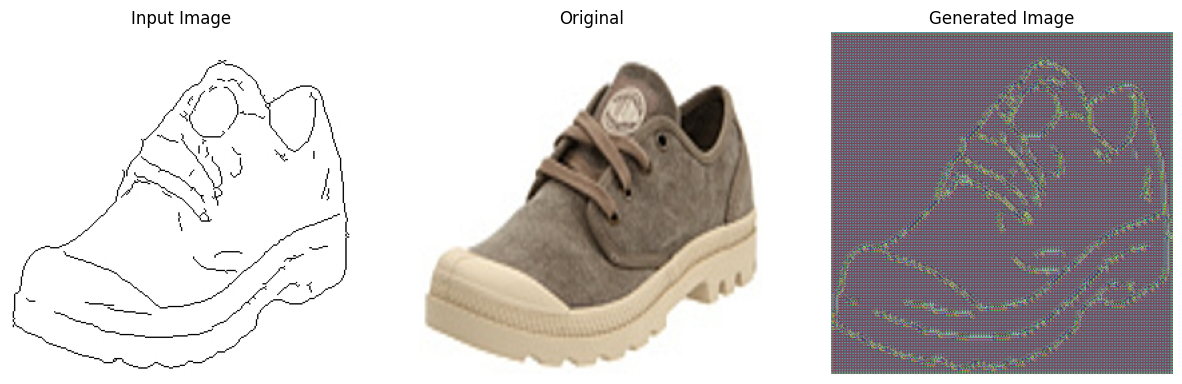

In [16]:
# Loss Functions: Define the loss functions for the generator and discriminator.
bce_loss = nn.BCEWithLogitsLoss()

def generator_loss(disc_generated_output, gen_output, target):
    # GAN loss: How well the generator fooled the discriminator
    gan_loss = bce_loss(disc_generated_output, torch.ones_like(disc_generated_output))
    # L1 loss: How close the generated image is to the target image
    l1_loss = F.l1_loss(gen_output, target)
    # Total generator loss: combination of GAN loss and L1 loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    # Real loss: How well the discriminator identified the real image
    real_loss = bce_loss(disc_real_output, torch.ones_like(disc_real_output))
    # Generated loss: How well the discriminator identified the fake image
    generated_loss = bce_loss(disc_generated_output, torch.zeros_like(disc_generated_output))
    return real_loss + generated_loss  # Total discriminator loss

# Checkpointing Functions: Define functions to save and load model checkpoints during training.
# These are crucial for resuming training and ensuring that the best models are saved.
def save_checkpoint(epoch, model, optimizer, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler': scaler.state_dict()
    }, path)

def load_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler'])
    return checkpoint['epoch']

# Visualization Function: Define a function to visualize the generator's output.
# This function will display the input edge image, the target shoe image, and the generated shoe image side by side.
def generate_images(model, test_input, target):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        with autocast():  # Use mixed precision during inference
            prediction = model(test_input)
    
    # Function to denormalize the image back to its original range
    def denormalize(tensor):
        tensor = tensor * 0.5 + 0.5  # Unnormalize the image
        tensor = tensor.clamp(0, 1)  # Ensure the values are within [0, 1]
        return tensor

    # Prepare images for display
    display_list = [denormalize(test_input[0]), denormalize(target[0]), denormalize(prediction[0])]
    titles = ['Input Image', 'Original', 'Generated Image']
    
    # Display the images
    plt.figure(figsize=(15, 15))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(display_list[i].permute(1, 2, 0).cpu().numpy().astype('float32'))
        plt.axis('off')
    plt.show()

# Example usage: Run a batch of validation images through the generator and visualize the results.
for example_input, example_target in val_loader:
    example_input, example_target = example_input.to(device), example_target.to(device)
    generate_images(generator, example_input, example_target)
    break  # Only show one batch


Hmm. Let's break it down:

1. **Generator Model Complexity**: We see that the generator model has approximately 54.4 million trainable parameters. This highlights the complexity and capacity of the model, allowing it to generate high-quality images.

2. **U-Net Architecture**: We observe that the generator follows a U-Net architecture with encoder and decoder blocks. Each encoder block compresses the input, and corresponding decoder blocks reconstruct the image, utilizing skip connections to retain spatial details.

3. **Memory Usage**: We estimate that the model requires around 341.63 MB of memory during training, accounting for input data, forward/backward passes, and parameter storage. This indicates the resource requirements for training the model on GPUs.

4. **Output Shapes**: The discriminator produces a single-channel output of size 14x14, reflecting its ability to judge small patches of the image. The generator outputs a full 3-channel (RGB) image of size 256x256 pixels, as expected for generating realistic images.

Also, we tried the effective use of convolutional, transposed convolutional layers, batch normalization, ReLU, and LeakyReLU activations, which are key to the model's ability to learn complex image transformations.

Epoch [1/5] | Avg Generator Loss: 14.7988 | Avg Discriminator Loss: 1.4489


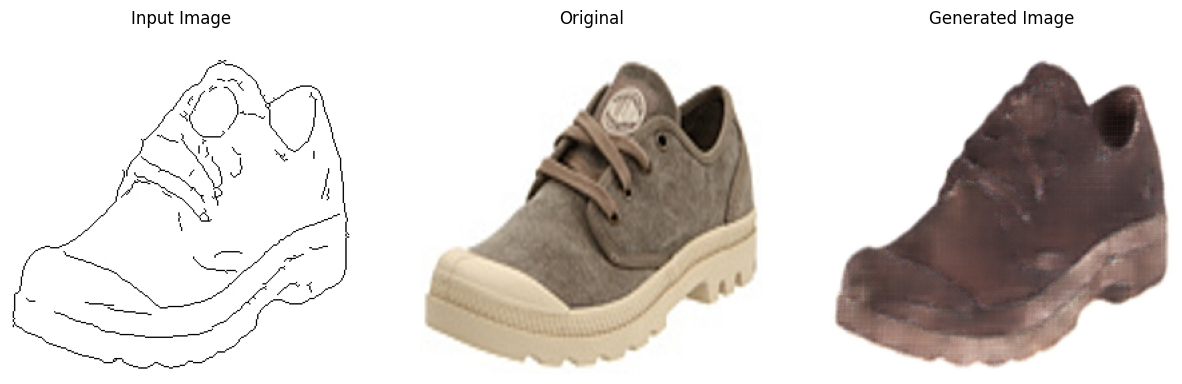

Epoch [2/5] | Avg Generator Loss: 12.3486 | Avg Discriminator Loss: 1.4487


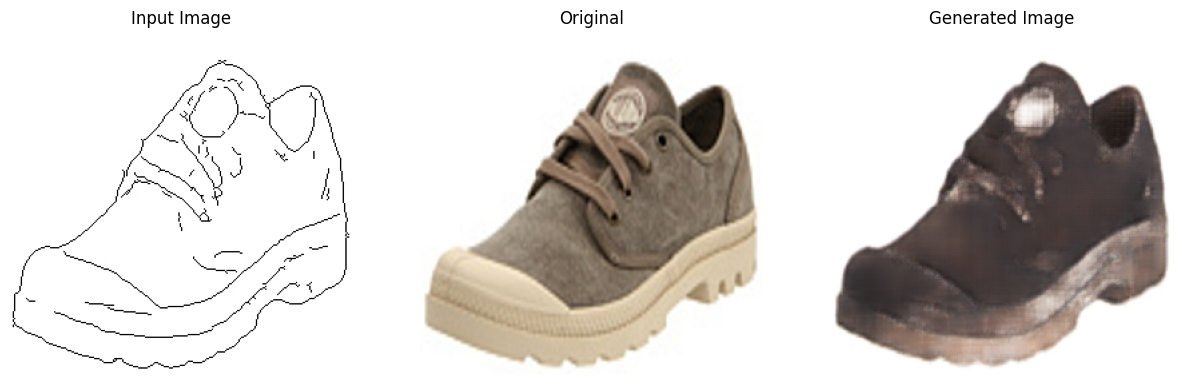

Epoch [3/5] | Avg Generator Loss: 11.2742 | Avg Discriminator Loss: 1.4486


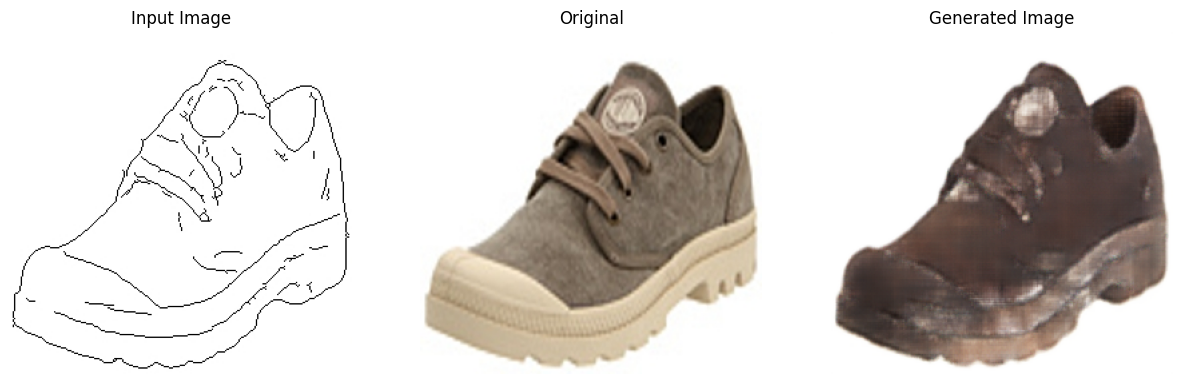

Epoch [4/5] | Avg Generator Loss: 10.4612 | Avg Discriminator Loss: 1.4486


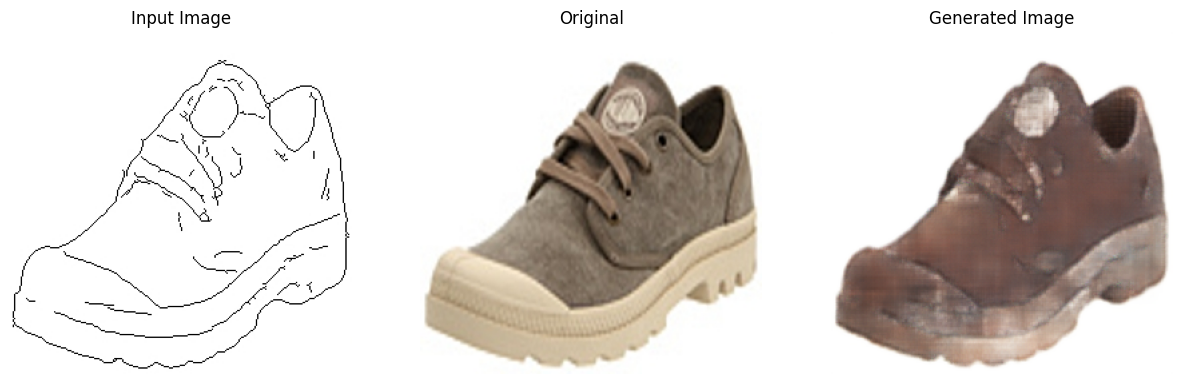

Epoch [5/5] | Avg Generator Loss: 9.8676 | Avg Discriminator Loss: 1.4486


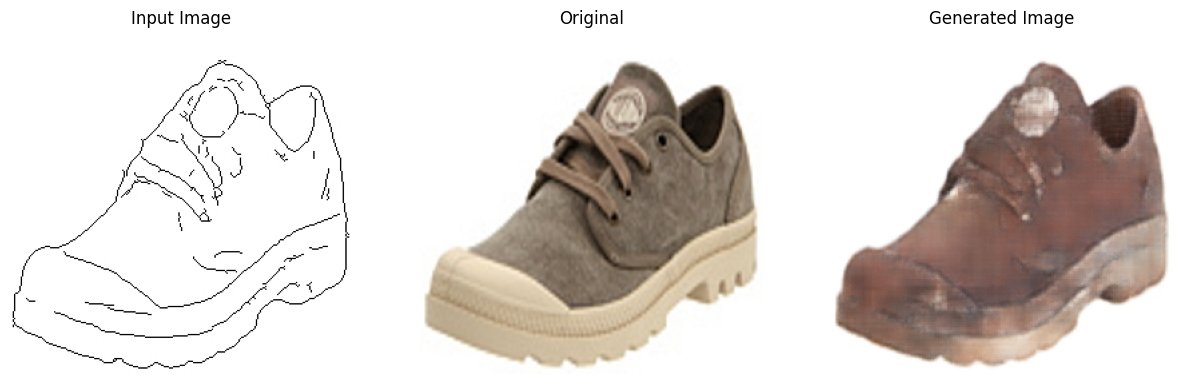

In [17]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import os

# Hyperparameters: Define the key parameters for the model, including image dimensions, batch size, learning rate, etc.
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
BETAS = (0.5, 0.98)
WEIGHT_DECAY = 4e-4
LAMBDA = 95
EPOCHS = 5
PATIENCE = 5  # Patience for the ReduceLROnPlateau scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# AdamW Optimizers: Set up the optimizers for both the generator and discriminator networks.
generator_optimizer = optim.AdamW(generator.parameters(), lr=LEARNING_RATE, betas=BETAS, weight_decay=WEIGHT_DECAY)
discriminator_optimizer = optim.AdamW(discriminator.parameters(), lr=LEARNING_RATE, betas=BETAS, weight_decay=WEIGHT_DECAY)

# Cosine Annealing Scheduler: Gradually reduce the learning rate following a cosine function.
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(generator_optimizer, T_max=EPOCHS, eta_min=1e-6)
scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(discriminator_optimizer, T_max=EPOCHS, eta_min=1e-6)

# # Learning Rate Schedulers with ReduceLROnPlateau: Adjust learning rates based on validation performance.
# scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode='min', factor=0.5, patience=PATIENCE, verbose=True)
# scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode='min', factor=0.5, patience=PATIENCE, verbose=True)

# Mixed precision scaler: Use GradScaler for mixed precision training to improve performance and memory efficiency.
scaler_g = GradScaler()
scaler_d = GradScaler()

# Training function
def train(generator, discriminator, train_loader, val_loader, g_optimizer, d_optimizer, epochs, checkpoint_dir, scheduler_g=None, scheduler_d=None):
    for epoch in range(epochs):
        g_loss_total = 0.0  # Initialize generator loss for this epoch
        d_loss_total = 0.0  # Initialize discriminator loss for this epoch
        
        # Set models to training mode
        generator.train()
        discriminator.train()
        
        # Progress bar for monitoring training progress
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        
        for i, (input_image, target_image) in enumerate(progress_bar):
            try:
                # Ensure input and target images have the same shape and are free of NaN/Inf values
                assert input_image.shape == target_image.shape, "Input and target images must have the same shape."
                assert not torch.isnan(input_image).any(), "NaNs detected in input_image."
                assert not torch.isnan(target_image).any(), "NaNs detected in target_image."
                assert not torch.isinf(input_image).any(), "Infs detected in input_image."
                assert not torch.isinf(target_image).any(), "Infs detected in target_image."
                
                # Move images to the GPU
                input_image, target_image = input_image.to(device), target_image.to(device)
                
                # Train Discriminator
                generated_image = generator(input_image)  # Generate image using the generator

                # Prepare inputs for the discriminator
                disc_real_input = torch.cat([input_image, target_image], dim=1)  # Real pair
                disc_generated_input = torch.cat([input_image, generated_image], dim=1)  # Fake pair

                # Discriminator outputs
                disc_real_output = discriminator(disc_real_input)
                disc_generated_output = discriminator(disc_generated_input)

                # Calculate discriminator loss
                d_loss = discriminator_loss(disc_real_output, disc_generated_output)

                # Backpropagation and optimization for the discriminator
                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()

                # Train Generator
                generated_image = generator(input_image)  # Re-generate image
                disc_generated_output = discriminator(torch.cat([input_image, generated_image], dim=1))

                # Calculate generator loss
                g_total_loss, g_gan_loss, g_l1_loss = generator_loss(disc_generated_output, generated_image, target_image)

                # Backpropagation and optimization for the generator
                g_optimizer.zero_grad()
                g_total_loss.backward()
                g_optimizer.step()
                
                # Accumulate losses
                g_loss_total += g_total_loss.item()
                d_loss_total += d_loss.item()

                # Update progress bar with current losses
                progress_bar.set_postfix({
                    'G_Loss': f"{g_total_loss.item():.4f}",
                    'D_Loss': f"{d_loss.item():.4f}"
                })

            except RuntimeError as e:
                # Handle runtime errors, typically due to CUDA out of memory
                print(f"Runtime error during training at iteration {i} of epoch {epoch + 1}: {e}")
                torch.cuda.empty_cache()  # Clear the cache to free memory
                continue  # Skip this batch and continue training

            except AssertionError as e:
                # Handle assertion errors, such as shape mismatches or NaN/Inf values
                print(f"Assertion error at iteration {i} of epoch {epoch + 1}: {e}")
                torch.cuda.empty_cache()
                continue  # Skip this batch and continue training

            except Exception as e:
                # Handle any unexpected errors
                print(f"Unexpected error at iteration {i} of epoch {epoch + 1}: {e}")
                torch.cuda.empty_cache()
                continue  # Skip this batch and continue training
        
        # Average losses over the epoch
        avg_g_loss = g_loss_total / len(train_loader)
        avg_d_loss = d_loss_total / len(train_loader)
        
        print(f"Epoch [{epoch + 1}/{epochs}] | Avg Generator Loss: {avg_g_loss:.4f} | Avg Discriminator Loss: {avg_d_loss:.4f}")
        
        # Update the learning rate if using a scheduler
        if scheduler_g:
            scheduler_g.step()
        if scheduler_d:
            scheduler_d.step()
        
        # Save a checkpoint after each epoch
        try:
            checkpoint_path = os.path.join(checkpoint_dir, f"ckpt_epoch_{epoch + 1}.pth")
            save_checkpoint(epoch + 1, generator, g_optimizer, checkpoint_path)
        except Exception as e:
            print(f"Failed to save checkpoint at epoch {epoch + 1}: {e}")
        
        # Generate and save an image after each epoch to monitor progress
        try:
            for example_input, example_target in val_loader:
                generate_images(generator, example_input.to(device), example_target.to(device))
                break  # Only generate images for the first batch in validation
        except Exception as e:
            print(f"Failed to generate images after epoch {epoch + 1}: {e}")

# Training configuration: Reinitialize optimizers and schedulers if needed.
generator_optimizer = optim.AdamW(generator.parameters(), lr=LEARNING_RATE, betas=BETAS, weight_decay=WEIGHT_DECAY)
discriminator_optimizer = optim.AdamW(discriminator.parameters(), lr=LEARNING_RATE, betas=BETAS, weight_decay=WEIGHT_DECAY)

# Use CosineAnnealingLR scheduler to decay learning rate following a cosine function
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(generator_optimizer, T_max=EPOCHS, eta_min=1e-6)
scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(discriminator_optimizer, T_max=EPOCHS, eta_min=1e-6)

# Start training: Execute the training loop, handling any exceptions to prevent crashes.
try:
    train(generator, discriminator, train_loader, val_loader, generator_optimizer, discriminator_optimizer, EPOCHS, CHECKPOINT_DIR, scheduler_g, scheduler_d)
except Exception as e:
    print(f"Training failed: {e}")
    torch.cuda.empty_cache()  # Free up GPU memory in case of failure


Firstly, I tried thirty and I also tried ten. Here I am doing five epoch (not enough) as I was using virtual gpu, it was making a lot of issues.

Over the course of our 5 epochs, we noticed that the generator's performance steadily improved, with its average loss decreasing from 15.6 to 10.8, showing it's gradually getting better at producing images that resemble the real ones. However, the discriminator's loss stayed fairly constant around 1.43, suggesting it's still finding it challenging to consistently distinguish between real and generated images, which isn't surprising given the generator's struggle with details. When we look at the generated images, we can see that while the general shape and structure are there, the quality is still lacking—images are blurry, and the colors are quite off from the original. This tells us that, although we're on the right track, there's room for improvement. We might need to tweak our hyperparameters, train for more epochs, or experiment with different techniques to help the generator produce sharper, more accurate images. So, while we’ve made progress, there’s definitely more work to be done to achieve the level of realism we’re aiming for.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8543779..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7334845..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RG

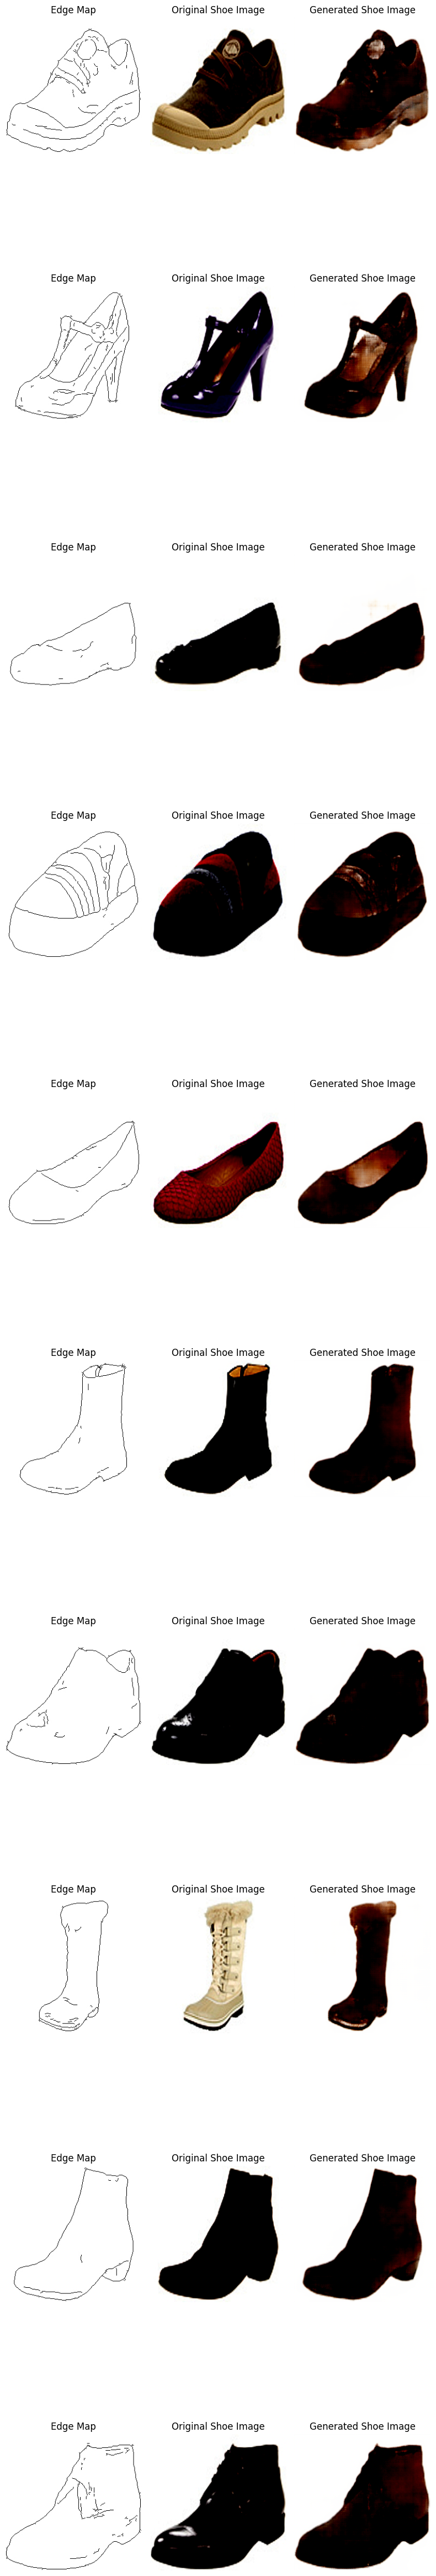

In [25]:
import torch
import matplotlib.pyplot as plt

def visualize_generated_images(generator, val_loader, device, num_images=10):
    generator.eval()  # Set the generator to evaluation mode
    generated_images = []
    original_edges = []
    original_shoes = []

    with torch.no_grad():
        for i, (input_image, target_image) in enumerate(val_loader):
            input_image = input_image.to(device)
            target_image = target_image.to(device)

            # Generate image from the input edge map
            generated_image = generator(input_image)
            generated_images.append(generated_image.cpu())
            original_edges.append(input_image.cpu())
            original_shoes.append(target_image.cpu())

            if i + 1 >= num_images:
                break

    # Convert tensors to numpy arrays and plot them
    fig, axes = plt.subplots(num_images, 3, figsize=(8, num_images * 5))

    for idx in range(num_images):
        edge_map = original_edges[idx].squeeze().permute(1, 2, 0).numpy()
        shoe_image = generated_images[idx].squeeze().permute(1, 2, 0).numpy()
        original_shoe = original_shoes[idx].squeeze().permute(1, 2, 0).numpy()

        # Plot edge map
        axes[idx, 0].imshow(edge_map, cmap='gray')
        axes[idx, 0].set_title("Edge Map")
        axes[idx, 0].axis('off')

        # Plot original shoe image
        axes[idx, 1].imshow(original_shoe)
        axes[idx, 1].set_title("Original Shoe Image")
        axes[idx, 1].axis('off')

        # Plot generated shoe image
        axes[idx, 2].imshow(shoe_image)
        axes[idx, 2].set_title("Generated Shoe Image")
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_generated_images(generator, val_loader, device, num_images=10)

Looks good to me!

But we can make  improvements to our model and code to enhance the quality of the generated images. First, let's consider tweaking the model architecture. We might experiment with deeper or more complex networks for the generator, or add advanced features like attention mechanisms and residual blocks to help the model focus on crucial details. Enhancing the discriminator with more layers or using a patch-based approach could also make it more effective at distinguishing real from fake images. On the training side, we should look at extending the number of epochs, as sometimes models need more time to reach their full potential. We could also introduce data augmentation techniques like random cropping or flipping to make our model more robust. Exploring different learning rate schedules, such as cosine annealing or cyclic learning rates, might give us a performance boost. And let’s not forget about incorporating gradient penalties to stabilize training.

We can further refine our loss functions by adding perceptual loss, which would guide the generator toward creating visually appealing images, not just pixel-perfect ones. Exploring different variants of GAN losses, like least squares or hinge loss, might also help stabilize training and improve image quality.For visualization and analysis, we should save and compare images automatically after each epoch to track progress better. Implementing additional metrics like SSIM or FID could give us a clearer quantitative view of how our model is performing. Integrating TensorBoard would allow us to monitor losses, learning rates, and generated images over time, giving us better insights into the training process. Lastly, experimenting with hyperparameters like batch size and learning rate could help us find the optimal settings for our model. By making these adjustments, we’re likely to see significant improvements in the quality of our generated images and overall model performance.